# Tittle and introduction

<h1> Exploratory Data Analysis Using Youtube Video Data From Most Popular Channel about Test And Rate Products </h1>

<h2> 1. Aims, objetives and background </h2>

1.1. Introduction

Since its founding in 2005, Youtube has grown to become the second largest search engine in the word (behind google) that processes more than 3 billion searches for month. [[1]](https://www.mushroomnetworks.com/infographics/youtube---the-2nd-largest-search-engine-infographic/). 
It is, however, generally a myth how the youtube algorithm work, what makes a video get views and be recomended over another. In fact, Youtube has one of the largest scale and more softificated insdustrial recomendation systems in existence. [[2]](https://dl.acm.org/doi/10.1145/2959100.2959190). For new content creators, it is a challenge to understans why a video gets views and others don't. There are many "myths" around the success of a Youtube video [[3]](https://vidiq.com/blog/post/5-youtube-algorithm-myths-youtubers-need-to-know-about/). for example if the video has more likes or comments, or if the video is of a certain duration. It is a also worth experimenting and looking for "trends" in the topics that Youtube channels are covering in a certain niche.

For create a web page where you can get the test and the rate about a specific product, i going to try obtain the data analysis of 3 popular channels in youtube about the topic of product reviews.

## 1.2 Aims and Objectives

Within this project, i would like to explore the following:

- Getting to know Youtube API and how to obtain video data.
- Analizing video data and verify diferent common myths about what make a video well on Youtube, for example:
- - Does the number of likes and comments matter for a video to get more views?
- - Does the video duration matter for views and interactions (likes/comments)?
- - Does the tittle length matter for views?
- - How many tags do good performing videos have? What are the common tags among these videos?
- - Across all creators, I take into consideration, how often do they upload new videos? On which days in the week?
- Explore trending topics using NLP techniques.
- - Which popular topics are beign covered in the videos (e.g. using wordcloud for video titles)
- - Which questions are being asked in the comment section in the video? 
- Save the transcript data for each video in each channel, and filter words for the product reviewed determination.

## 1.3 Steps of the projects 

1. Obtain video meta data via YouTube API for the top 3 channels in the product review niche (this include several small steps: create a developer key, request data and transform the responses into a usable data format).
2. Prepocess data and engineer addicional feactures for analisys.
3. Exploratory data analisis.
4. conclusions.

## 1.4 Data set

### Data selection

As this project is particularly focused on product review channels, I found that no many, readily available datasets online are suitable for this purpose. The 2 alternative datasets i found are:

1. [Youtube Trending Video Dataset](https://www.kaggle.com/datasnaek/youtube-new): This dataset contains several months of data on daily trending YouTube videos for several contries. There are up to 200 trending videos per day. However this dataset is not fit for this project because the trending videos are about wide range of topics that are not product reviews.
2. Another data set is obtained from [ Gitlab repo ](https://gitlab.com/thebrahminator/Youtube-View-Predictor) of Vishwanath Seshagiri, which is thr metadata of 0.5M+ YouTube videos along with their channel data. There is no clear documentation on how this data set was created, but a quick look at the datasets in the repository, suggested taht the data was obtained using keyword search of popular keywords such as "football" or "science". There are also some relevant keywords  such as "python". However, i decided not to use these dataset because they don't contain data for the channels I am interested in.

I created my own data set using the [Google YouTube API v3.0](https://developers.google.com/youtube/v3). The exact steps of data creation is presented in section 2. Data creation bellow.

### Data limitations

The dataset is a real-world dataset and suitable for the research. However, the selection of the 3 channels to include in the research is purely based on my knoledge of the channels in spanish product review field and might not be accurate. My definition is "popular" is only fbased on subscriber count but there are others metrics that could be taken into consideration as well (e.g. views, engagement).

### Ethics of data source

According to [YouTube API's guide](https://developers.google.com/youtube/v3/getting-started) the usage of Youtube API is free os charge given that your application send requests within a quota limit. "The Youtube Data API uses a quota to ensure that developers  use thr services as intended and do not create applications that unfairlyreduce services quality or limit acces to others." The default quota allocation for each application is 10,000 units per day, and and you could request additional quota by completing a form to youtube API servicess if you reach the quota limit.

Since all data requested from Youtube API is public data (which everyone on the internet can see on youtube), there is not particular privacy issues as far as I am concerned. In addition, the data is obtained only for research purposes in this case and not for any comercial interests.

In [1]:
# Data tools packages
import pandas as pd
import numpy as np
from dateutil import parser
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Date time packages
import isodate

# Google API packages
from googleapiclient.discovery import build

In [2]:

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joan1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joan1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data creation with Youtube API

I first created a project on Google Developers Console, then requested an authorization credential (API key), Afterwards, I enabled Youtube API for my application, so that I can send API requests to Youtube API services. Then, I went on Youtube and checked the channel ID of each channel I want to included in my research scope. (Using the get channel id funtion). Then i created the funtions for getting the channel statistics via the API.

In [3]:
api_key=""

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)


In [5]:
list_channel_name = "Pongamosloapruebaoficial","PONGAMOSLOAPRUEBACORTOS1", "soyelbaroneshorts"


In [6]:
import requests

def get_channel_id(api_key, channel_name):
    """
        Get channel ID from channel name
        
        Params:
        ------
        api_key: Youtube API key
        channel_name: name of channel
        
        Returns:
        ------
        channel ID

    """
    url = f"https://www.googleapis.com/youtube/v3/search?part=id&type=channel&q={channel_name}&key={api_key}"
    response = requests.get(url)
    data = response.json()
    channel_id = data["items"][0]["id"]["channelId"]
    return channel_id

def get_channel_stats(youtube, channel_ids: list):
    
    """
        Get channel stats
        
        Params:
        ------
        youtube: build object of Youtube API
        channel_ids: list of channel IDs
        
        Returns:
        ------
        dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {
            'channelName': item['snippet']['title'],
            'country': item['snippet']['country'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
        Get video IDs from playlist ID
        
        Params:
        ------
        youtube: build object of Youtube API
        playlist_id: playlist ID
        
        Returns:
        ------
        list of video IDs
        
    """
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids
    
    
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

### Get channel statistics

Using the functions get_channel_id and get_channel_stats defined below, now we can get the channels id and get the channels statistics for the three channels we are interested in.

In [7]:
# Get channels id from channel name
channels_ids=[get_channel_id(api_key,channel_name) for channel_name in list_channel_name]
channels_ids

['UC8pLDwR20LGX2B4k9sJ4ZIw',
 'UCPx9eXszFK8rkivV7tXZpHA',
 'UCUyyfad7aWH7C382w10rVOw']

In [8]:
channels_data = get_channel_stats(youtube, channels_ids)

Now I can print out the data and take a look at the channel statistics overview.

In [9]:
channels_data

,channelName,country,subscribers,views,totalVideos,playlistId
0,Soy el Barone #Shorts,MX,517000,238809516,367,UUUyyfad7aWH7C382w10rVOw
1,PONGAMOSLO A PRUEBA CORTOS,MX,11600000,6889949392,586,UUPx9eXszFK8rkivV7tXZpHA
2,Pongamoslo a prueba,MX,4200000,458960435,144,UU8pLDwR20LGX2B4k9sJ4ZIw


I noticed the counts columns in channel_data is currently in string format, so I will convert them into numeric, so that we can visualize and do numeric operations on them.

In [10]:
number_columns=channels_data.columns[2:5]
channels_data[number_columns]=channels_data[number_columns].apply(pd.to_numeric,errors='coerce')
channels_data=channels_data.convert_dtypes()
channels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   channelName  3 non-null      string
 1   country      3 non-null      string
 2   subscribers  3 non-null      Int64 
 3   views        3 non-null      Int64 
 4   totalVideos  3 non-null      Int64 
 5   playlistId   3 non-null      string
dtypes: Int64(3), string(3)
memory usage: 281.0 bytes


Let's take a look at the number of subcribers per channel to have a view of how popular the channels are when compared with one another.

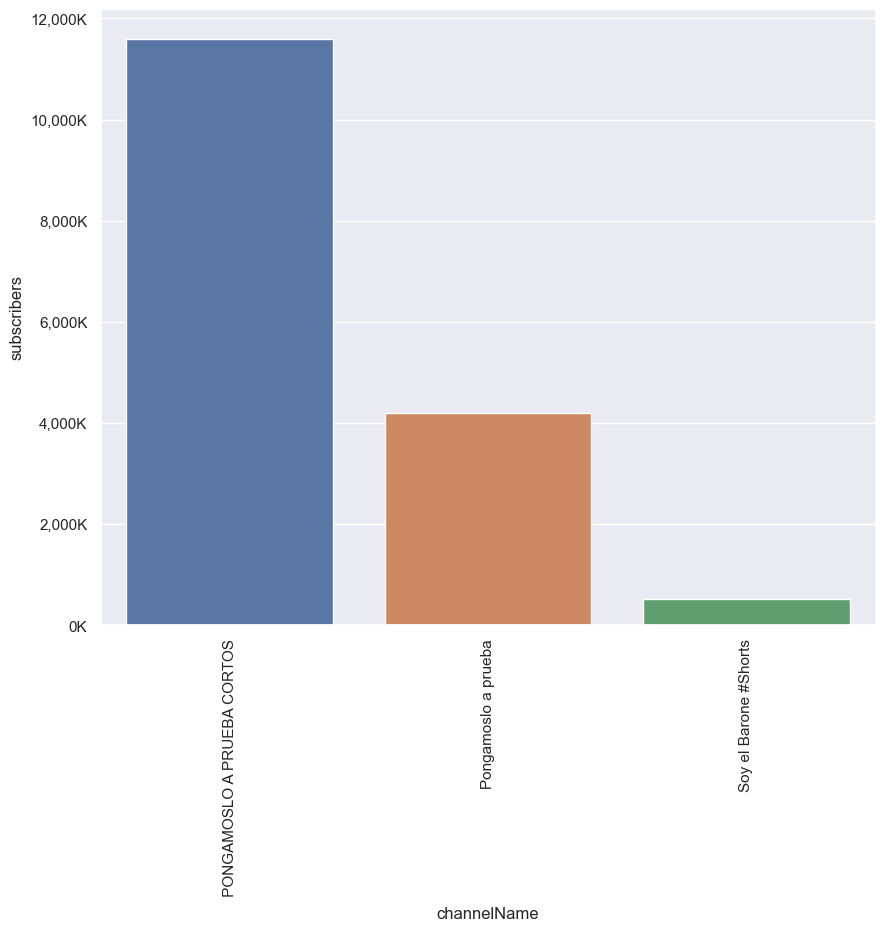

In [11]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channels_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Next, we will look a the rank considering the total number of views by channels.
The rank is fairly similar to the subcriber count rank, which is expected. PONGAMOSLO A PRUEBAS CORTOS is the most popular channel considering both subscribers and views. In the same way, the difference between the 3 channles is very sidnificant.

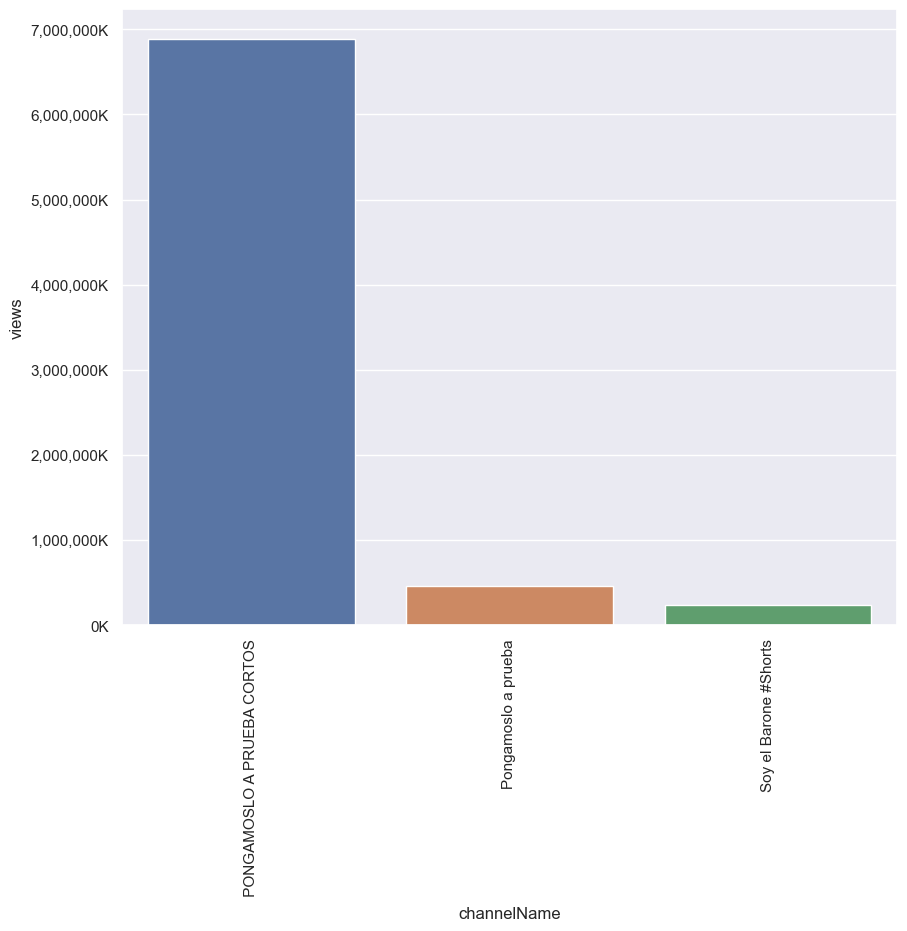

In [12]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='views', data=channels_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

### Get videos statistics for each 

In the next step, we will obtain the video statistic for all the channels. In total, we obtained over 1000 videos fronm the three channels.

In [13]:
channels_data.columns

Index(['channelName', 'country', 'subscribers', 'views', 'totalVideos',
       'playlistId'],
      dtype='object')

In [14]:
id_videos=[get_video_ids(youtube,i) for i in list(channels_data['playlistId'])]
id_videos=[item for sublist in id_videos for item in sublist]
comments_df=get_comments_in_videos(youtube,id_videos)

Could not get comments for video ulz3r3kegyI
Could not get comments for video -yggLlrFzZU
Could not get comments for video gyl9deduaOk


In [15]:
videos_df=get_video_details(youtube,id_videos)

In [16]:
videos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        1098 non-null   object
 1   channelTitle    1098 non-null   object
 2   title           1098 non-null   object
 3   description     1098 non-null   object
 4   tags            792 non-null    object
 5   publishedAt     1098 non-null   object
 6   viewCount       1098 non-null   object
 7   likeCount       1098 non-null   object
 8   favouriteCount  0 non-null      object
 9   commentCount    1098 non-null   object
 10  duration        1098 non-null   object
 11  definition      1098 non-null   object
 12  caption         1098 non-null   object
dtypes: object(13)
memory usage: 111.6+ KB


In [17]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   video_id  1095 non-null   object
 1   comments  1095 non-null   object
dtypes: object(2)
memory usage: 17.2+ KB


Let's take a look at the videos dataframe, all columns will help us to do the analisys eccept the favoriteCount column, which is always 0. so we can drop it.

In [18]:
videos_df.sample(3)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
416,SRqOF4lAyBk,PONGAMOSLO A PRUEBA CORTOS,el manjar de los dioses?,,None,2023-05-14T23:29:22Z,3818935,476709,None,1701,PT58S,hd,false
444,lWC5sCELAzU,PONGAMOSLO A PRUEBA CORTOS,Truco para estampar cualquier diseño en tu pla...,Canal principal: https://www.youtube.com/c/Pon...,None,2023-03-09T23:41:28Z,6978135,576103,None,1262,PT57S,hd,false
795,jMdk4zUvekU,PONGAMOSLO A PRUEBA CORTOS,Inovador invento paras quitar la comezon de lo...,,"[shorts, cortos, pongamoslo a prueba, mosquito...",2021-09-22T22:11:17Z,18169594,2228266,None,5659,PT58S,hd,false


Let's take a Look at the comments dataframe, We only get 1090 comments in total from over 1000 videos, due to the fact that we limited to 10 first comments per video to avoid exceeding the youtube API quota limit.

In [19]:
comments_df.sample(3)

,video_id,comments
625,gtzPT6u01dA,"[Como se llama el producto, Y como se llama el..."
1024,Es_hDKup5h4,[Dejen sus preguntas para el video de las 100 ...
1085,JAhj9y5K8BQ,[tendre cuidado pero por ejemplo para un traba...


In [20]:
# Write df to csv for future references
videos_df.to_csv('videos_df.csv', index = False)
comments_df.to_csv('comments_df.csv', index = False)
channels_data.to_csv('channels_data.csv', index = False)

## Preprocessign and feature ingeneering

To be able to make use of the data fon analisys, we need to perfom a few pre-processing steps.

Firstly, I would like reformat some columns, especially the date and time columns such as "publishedAT" and "duration".

In addition, I also think it is necessary to enrich the data with some new features that might be useful for understanding the video's characteristics.

Check for empty values in the data frame.

In [21]:
videos_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

There is not strange date in the publishedAt column, so we can convert it to datetime format. Published range 2018-2023

In [22]:
videos_df.publishedAt.sort_values(ascending=False).value_counts()

publishedAt
2021-05-24T22:45:00Z    2
2021-12-15T00:04:34Z    1
2021-12-05T21:59:33Z    1
2021-12-07T22:24:27Z    1
2021-12-08T22:13:34Z    1
                       ..
2023-02-15T01:00:37Z    1
2023-02-14T14:30:24Z    1
2023-02-13T14:30:06Z    1
2023-02-12T13:30:08Z    1
2018-06-15T22:04:39Z    1
Name: count, Length: 1097, dtype: int64

Like in the previus channels data, the counts columns are in string format and we will convert then into numeric. We will also convert the publishedAt column into timeDelta format. Also we will add the columns countTags for analisys.

In [23]:
def convert_count_columns_to_numeric(df: pd.DataFrame, count_cols: list):
    # Convert count columns to numeric
    df[count_cols] = df[count_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)
    return print('Columns converted to numeric: ' + str(count_cols))

def create_publishedAt_columns(df: pd.DataFrame):
    df['publishedAt'] = df['publishedAt'].apply(lambda x: pd.to_datetime(x))
    df['publishedAtHour'] = df['publishedAt'].apply(lambda x: x.strftime("%H"))
    df['publishedAtDay'] = df['publishedAt'].apply(lambda x: x.strftime("%A"))
    df['publishedAtMonth'] = df['publishedAt'].apply(lambda x: x.strftime("%B"))
    return print('Columns created: publishedAtHour, publishedAtDay, publishedAtMonth')

def duration_column_to_date(df: pd.DataFrame):
    # df['duration'] = df['duration'].apply(lambda x: parser.isoparse(x))
    df['duration'] = df['duration'].apply(lambda x: isodate.parse_duration(x))
    df['durationSecs'] = df['duration'].apply(lambda x: x.total_seconds())
    return print('Column converted to date: duration')

def create_count_tags_column(df: pd.DataFrame):
    df["countTags"] = df["tags"].apply(lambda x: len(x) if x != None else 0)
    return print('Column created: countTags')

Enriching the data with new features

I want to enriching data for futher analyses, for example:

- create published date column with another column showing  the day, the month and the hour in the week the video was published, wich will be useful for later analisys.

- convert the video duration in seconds instead of the current string format.

- calculate the number of tags for videos.

- calculate comments and likes per 1000 views ratio.

- calculate title character length.



In [24]:
convert_count_columns_to_numeric(videos_df, ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'])
create_publishedAt_columns(videos_df)
duration_column_to_date(videos_df)
create_count_tags_column(videos_df)

Columns converted to numeric: ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']


Columns created: publishedAtHour, publishedAtDay, publishedAtMonth
Column converted to date: duration
Column created: countTags


In [25]:
# Comments and likes per 1000 view ratio
videos_df['likeRatio'] = videos_df['likeCount']/ videos_df['viewCount'] * 1000
videos_df['commentRatio'] = videos_df['commentCount']/ videos_df['viewCount'] * 1000
# Title character length
videos_df['titleLength'] = videos_df['title'].apply(lambda x: len(x))

Let's look at the video dataset at this point to see if everything went well. It looks good - now we will proceed to exploratory analysis part.

In [26]:
videos_df.head(3)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,...,definition,caption,publishedAtHour,publishedAtDay,publishedAtMonth,durationSecs,countTags,likeRatio,commentRatio,titleLength
0,iMqcHwangKQ,Soy el Barone #Shorts,Probando el mini drone boomerang viral de Inte...,#shorts #espanhol #puebras \nEl enlace a todos...,"[puebra, productos, pruebas, viral, curisosida...",2023-09-09 18:00:17+00:00,40560.0,6895.0,NaN,22.0,...,hd,false,18,Saturday,September,57.0,5,169.995069,0.542406,50
1,Z2nCn1bYqBY,Soy el Barone #Shorts,Este truco te enseña a abrir el auto SIN las l...,#shorts #espanhol #puebras \nEl enlace a todos...,"[puebra, productos, pruebas, viral, curisosida...",2023-09-09 14:30:09+00:00,40026.0,4780.0,NaN,50.0,...,hd,false,14,Saturday,September,56.0,5,119.422375,1.249188,51
2,Nny4_6F-uU8,Soy el Barone #Shorts,👉 ENLACE de los productos aquí.,👇🏼ENLACE DE LOS PRODUCTOS AQUÍ👇🏼\nhttps://link...,"[puebra, productos, pruebas, viral, curisosida...",2023-09-09 01:18:19+00:00,2943.0,214.0,NaN,20.0,...,hd,false,01,Saturday,September,62.0,5,72.714917,6.795787,31


## Exploratory analysis

### Views distribution per channel

With the video statistics for all channel, now we can see how **the views are distributed per channel.** Some channels might have a lot of views on one of their videos and the rest do not receive many views.
 
Other channels might have more evenly distribution views per video. It can be observed that "PONGAMOSLO A PRUEBA CORTOS" and "pongamoslo a prueba" have a good views distribution in its videos, "instead soy el Barone #shorts" has a few videos with a lot of views. But is better to see the distribution of views per channel separately.

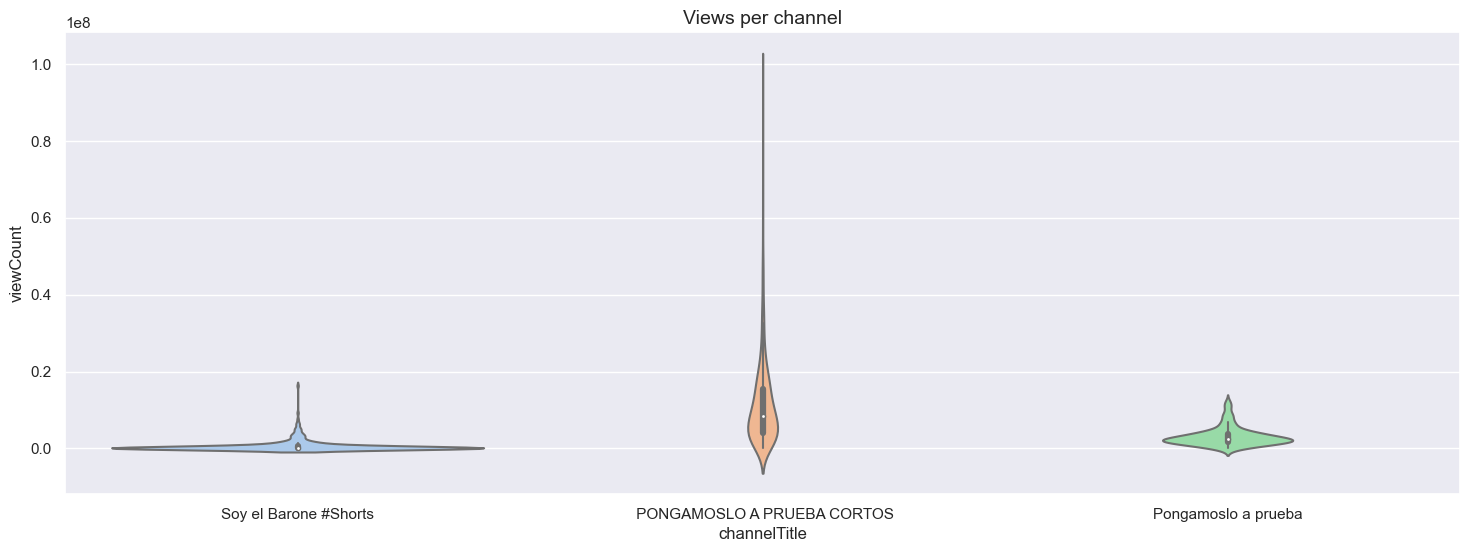

In [27]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x=videos_df['channelTitle'], y=videos_df['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

In [28]:
dict_channel_titles= dict(enumerate(videos_df['channelTitle'].unique()))
dict_channel_titles

{0: 'Soy el Barone #Shorts',
 1: ' PONGAMOSLO A PRUEBA CORTOS',
 2: 'Pongamoslo a prueba'}

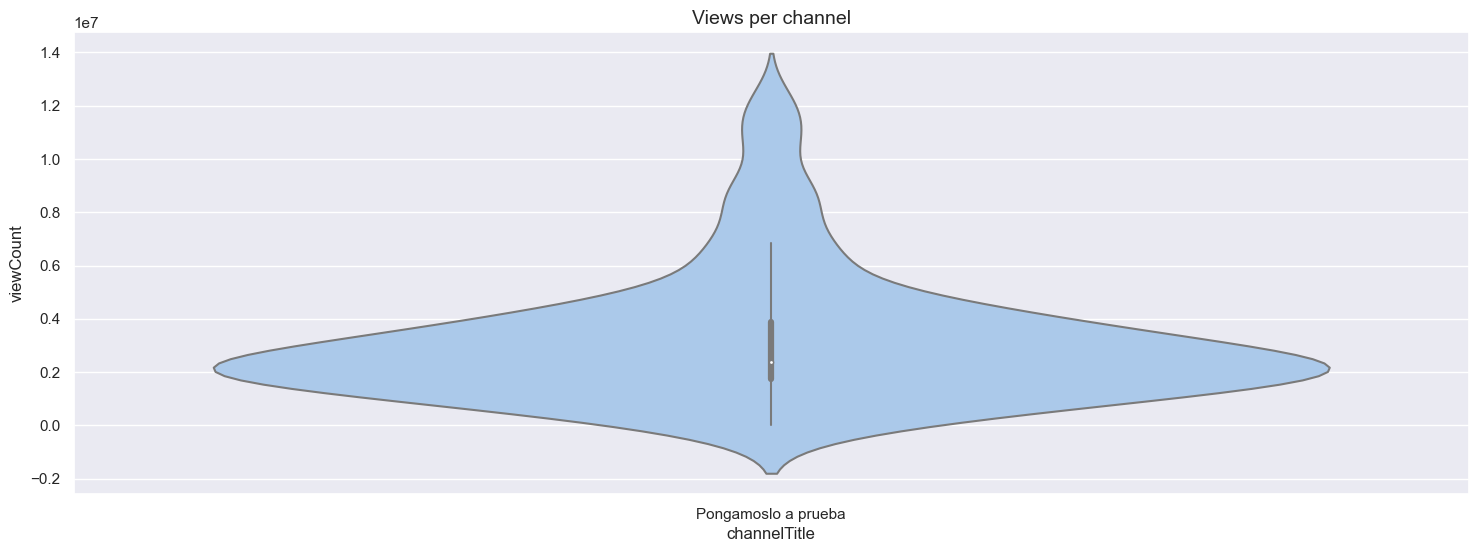

In [29]:
# mask for separate channels tittles in the graph
mask = (videos_df['channelTitle'].isin([dict_channel_titles[2]]))
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x=videos_df[mask]['channelTitle'], y=videos_df[mask]['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

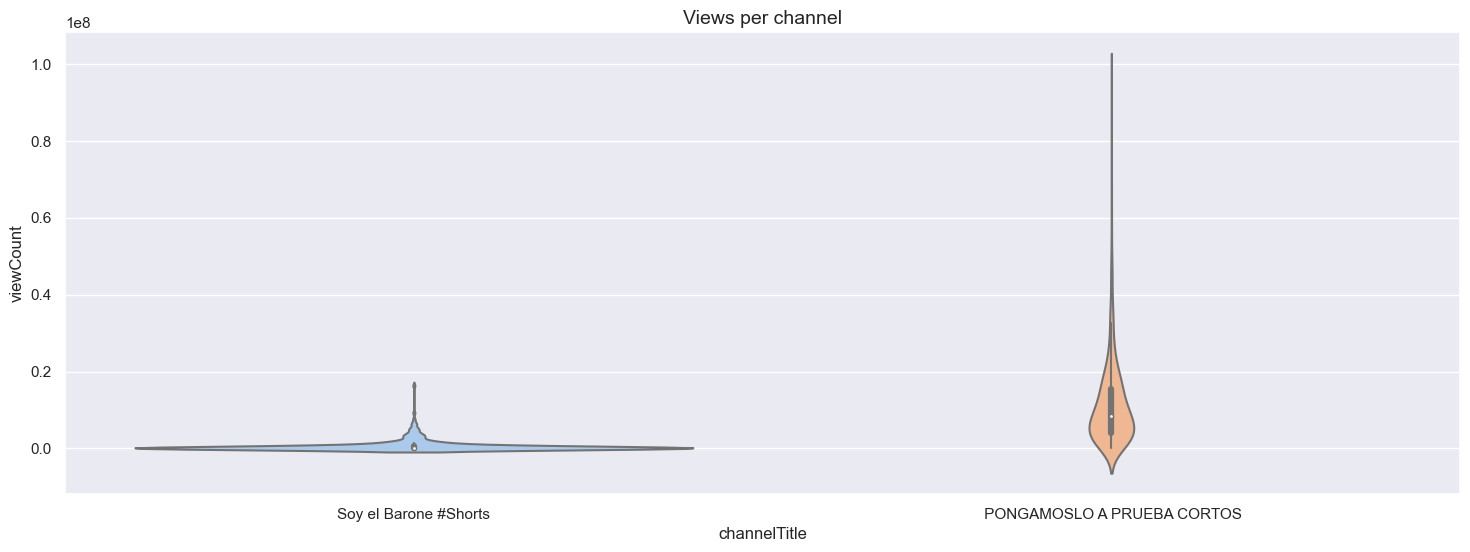

In [30]:
# mask for separate channels tittles in the graph
mask = (videos_df['channelTitle'].isin([dict_channel_titles[0],dict_channel_titles[1]]))
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x=videos_df[mask]['channelTitle'], y=videos_df[mask]['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

### Does the number of likes and comments matter for a video to get more likes?

Firstly, I would like to check if comments and likes do correlate with how many views a video would get. 

In the plots below, it can be observed that the number of views and number of comments/likes strongly correlate with each other.

The number of likes  seems to suggest stronger correlation than the numbers of comments.

However this is expected as the more people waching a video, the more likely the video will get comments and likes.

To correct for this factor, we will plot these relationships again but this time we will use the ratio of comments/likes per 1000 views.

<Axes: xlabel='likeCount', ylabel='viewCount'>

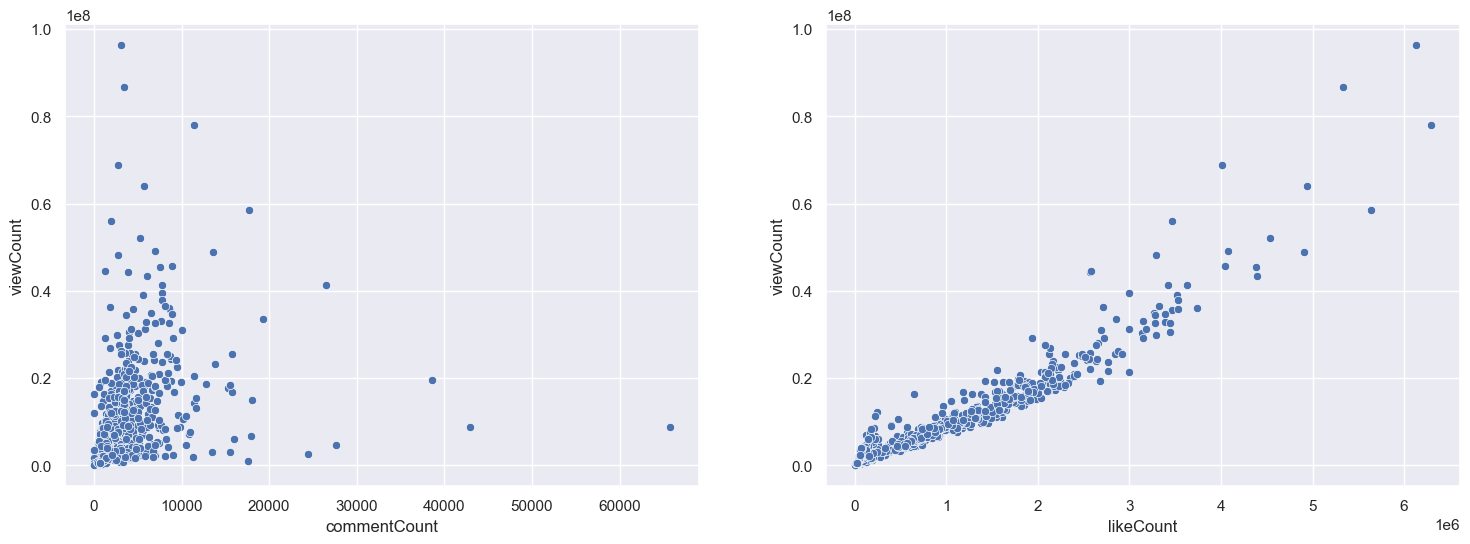

In [31]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = videos_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = videos_df, x = "likeCount", y = "viewCount", ax=ax[1])

Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number.

<Axes: xlabel='likeRatio', ylabel='viewCount'>

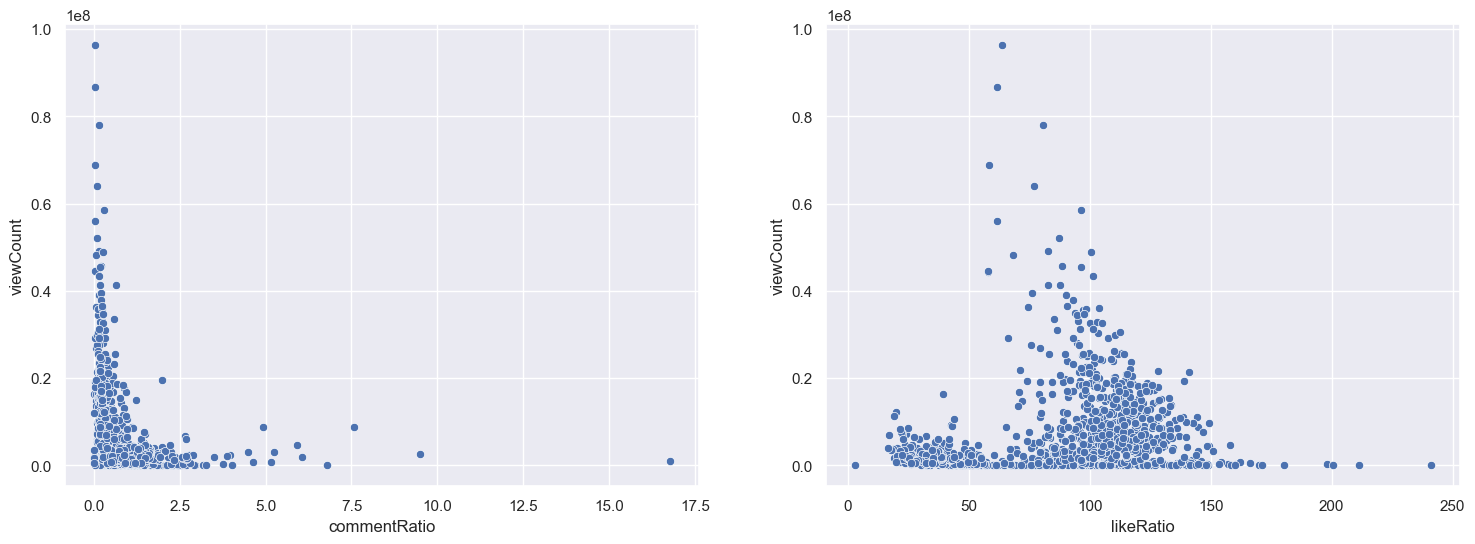

In [32]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = videos_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = videos_df, x = "likeRatio", y = "viewCount", ax=ax[1]) #(no entiendo)

After correcting for the absolute number of views, it turns out that the correlation is much less clear. The comment-view relationship seems to completely disappear: a lot of videos have millions of views and very few comments, while some videos have very few views have better interaction. However, it is understandable that comments take more effort than views and likes, and normally comments would die off when the video gets older.

As for like-view relatioship, we can still see some positive correlation between views and like ratio (though very subtle), which means that the more views a video has, the more people would hit the like button! This seems to support the idea of social proof, which means that people tend to like better the products that are already liked by many other people.

### Does the video duration matter for views and interaction (likes/ comments)?

As can be seen in the histogram below, most videos are between 0 to 100 seconds, which is about 1 to 2 minutes the reason is because two of the three channels are channels orienting to shorts videos. Here I have to limit the duration to 10,000 because of some really long videos (potentially streaming videos).

<Axes: xlabel='durationSecs', ylabel='Count'>

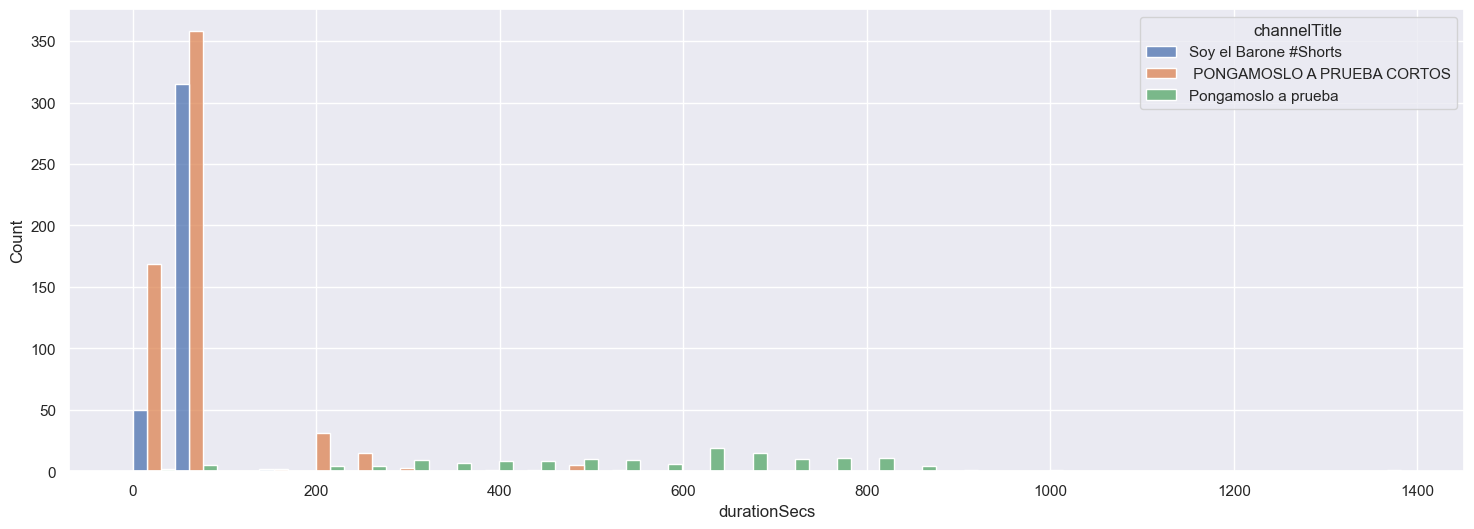

In [33]:
sns.histplot(data=videos_df[videos_df['durationSecs'] < 10000], x="durationSecs", bins=30, hue="channelTitle", multiple="dodge")

Now we plot the duration against comment count and like count. It can be seen that actually shorter videos tend to get more likes and comments than very long videos.

<Axes: xlabel='durationSecs', ylabel='likeCount'>

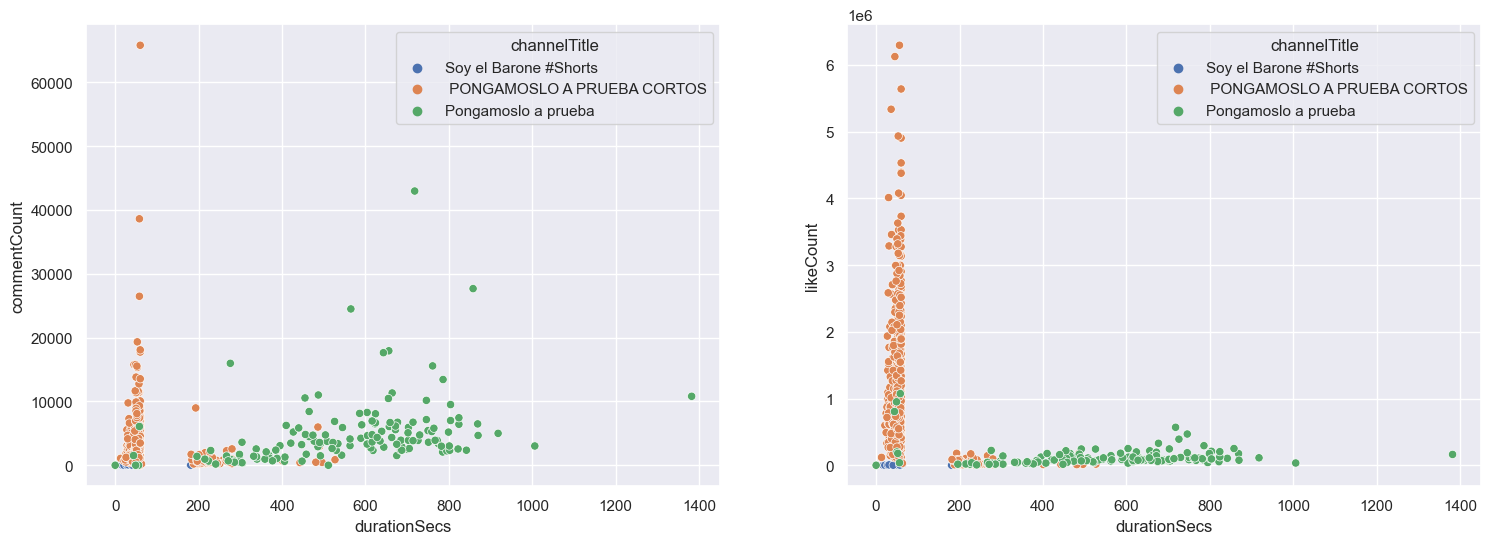

In [40]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = videos_df, x = "durationSecs", y = "commentCount", ax=ax[0], hue="channelTitle", palette="deep")
sns.scatterplot(data = videos_df, x = "durationSecs", y = "likeCount", ax=ax[1], hue="channelTitle", palette="deep")

### Does title length matter for views?

There is no clear relationship between title length and views as seen the scatterplot below.

<Axes: xlabel='titleLength', ylabel='viewCount'>

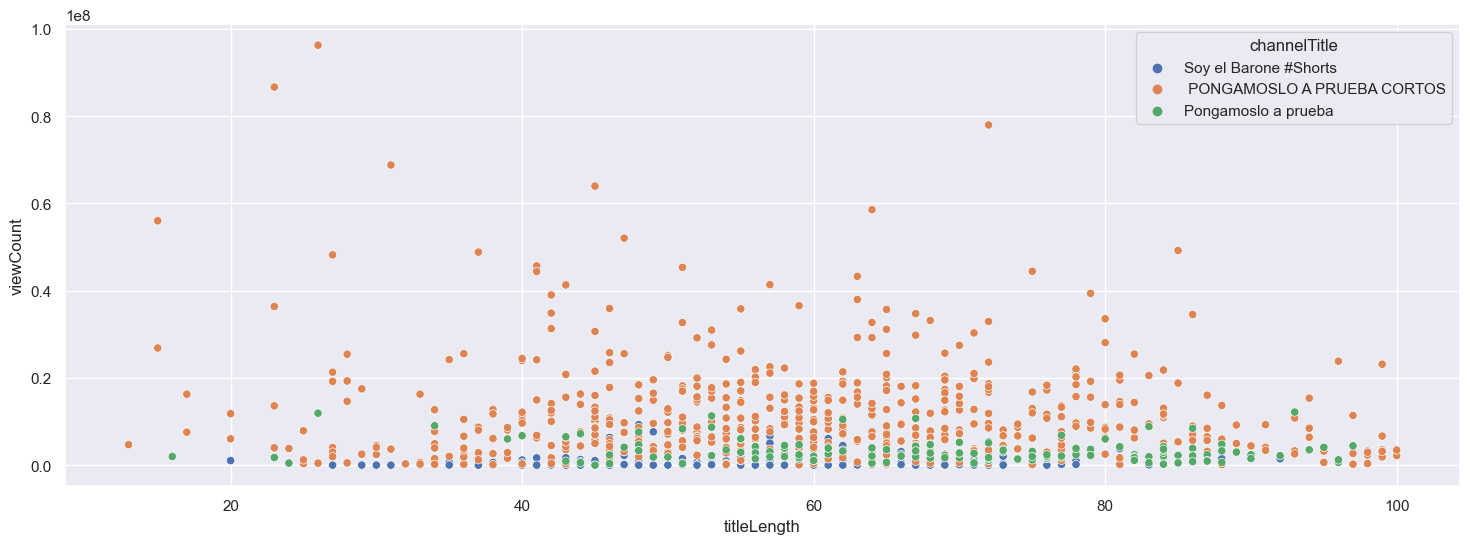

In [41]:
sns.scatterplot(data = videos_df, x = "titleLength", y = "viewCount", hue="channelTitle", palette="deep")

### Wordcloud for words in title

As I'm interested to see what the creators are making videos about and which terms most frequently appear in their video titles, I will create a wordcloud for the most common words. We first need to remove the spanish stopwords such as "tu", "yo", "el", etc. which do note contribute a lot to the meaning of the title.

In [54]:
stop_words = set(stopwords.words('spanish')+["prueba", "Short","short", "Pongamoslo", "Este"])
videos_df['title_no_stopwords'] = videos_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in videos_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

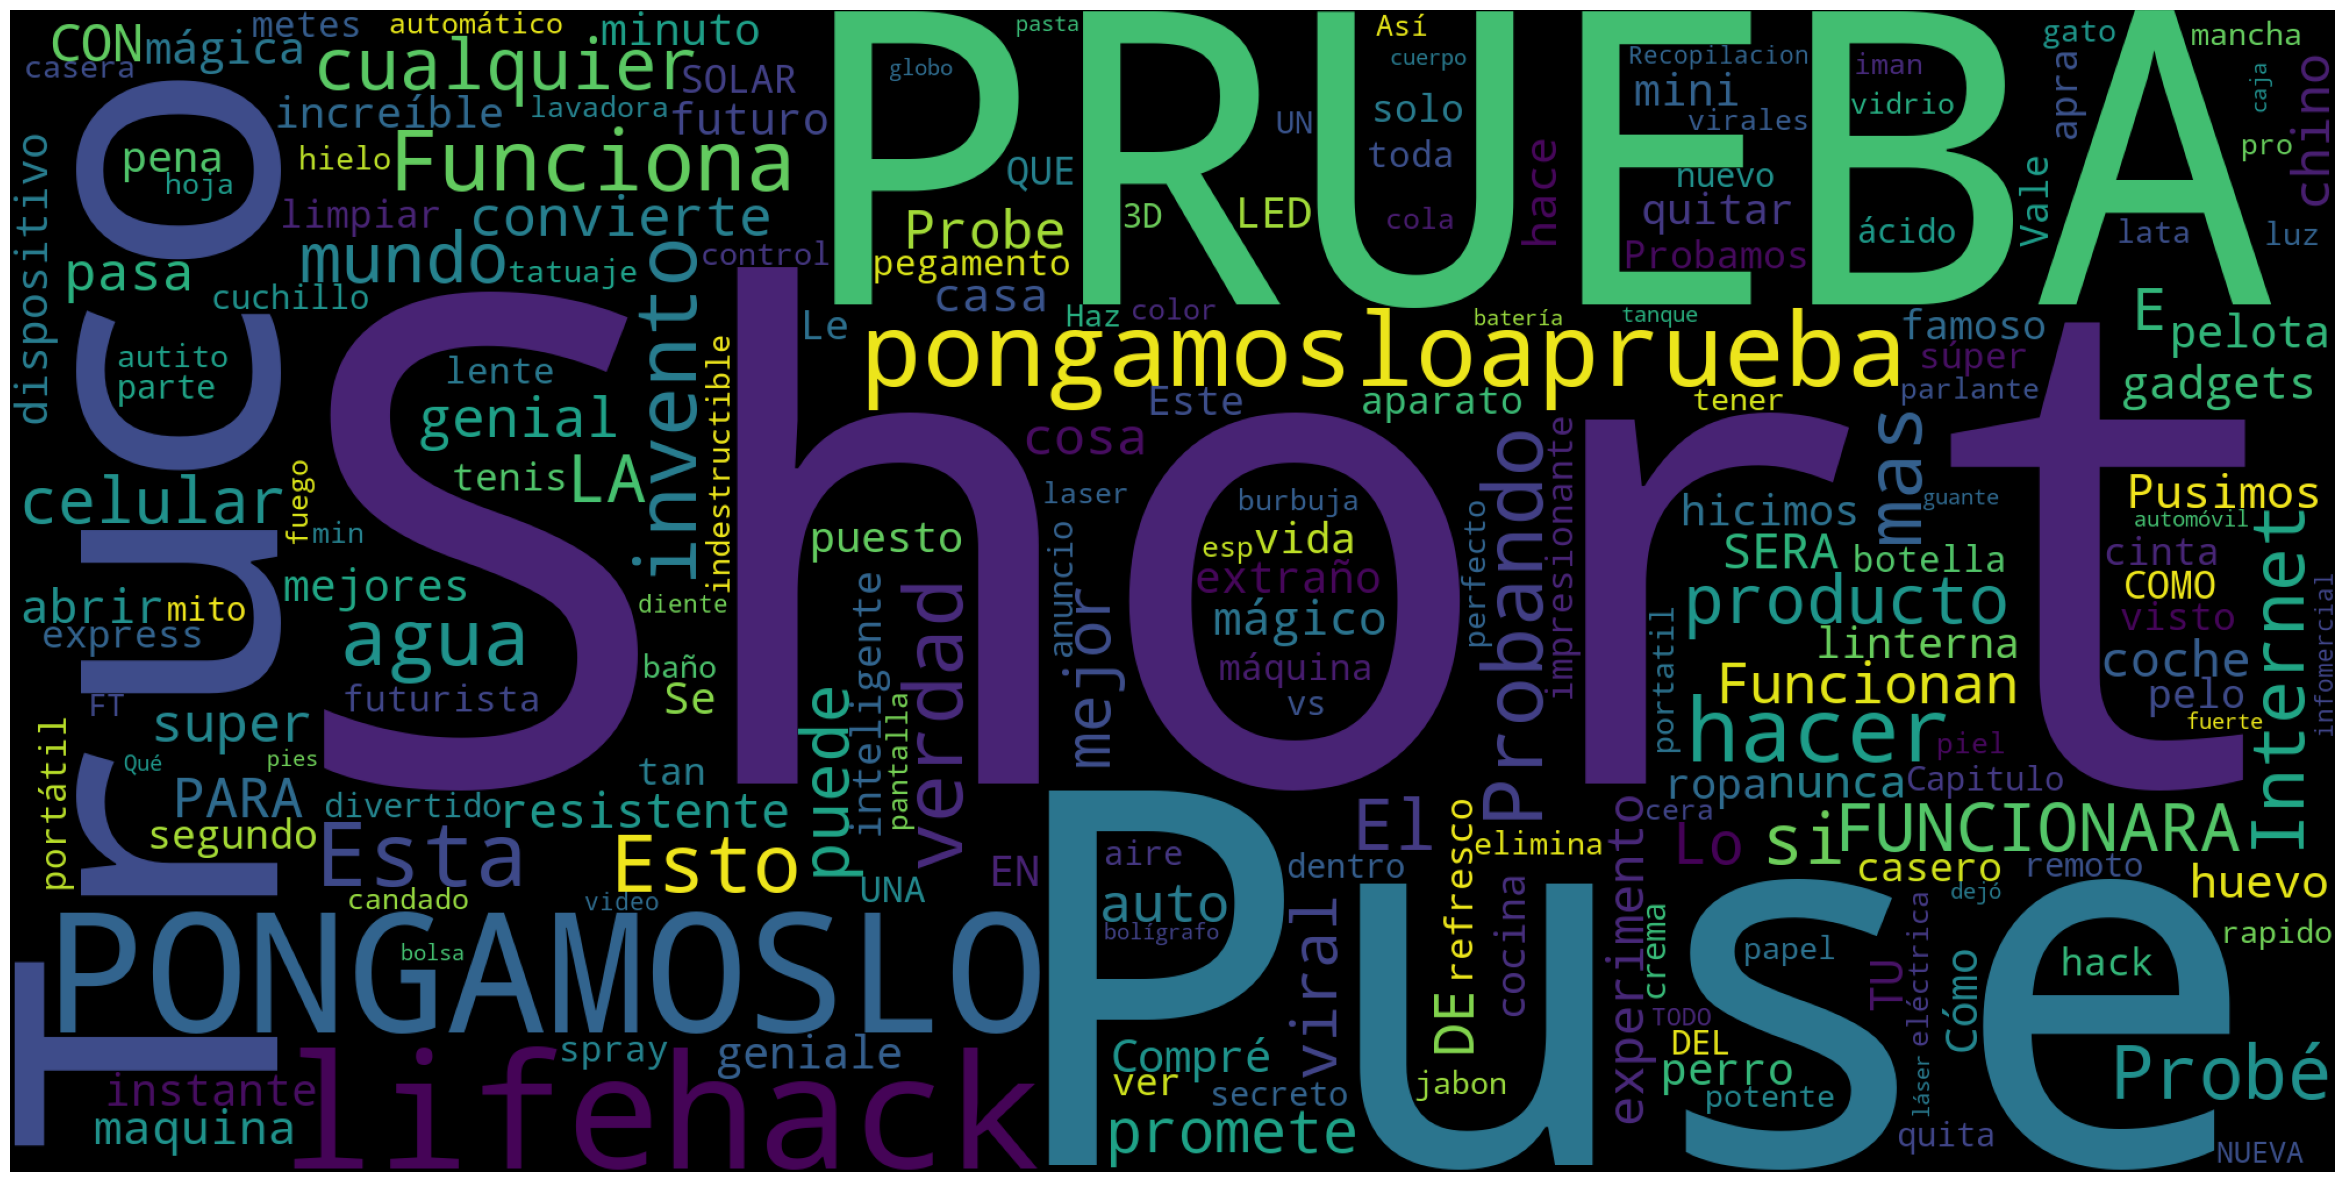

In [56]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)


It can be seen that most common words are short by the big channel "PPONGAMOSLO A PRUEBA SHORTS", Puse, Truco, which is very expected.

### Number of tags vs views

It seems that most videos have between 5 and 30 tags. The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views.

<Axes: xlabel='countTags', ylabel='viewCount'>

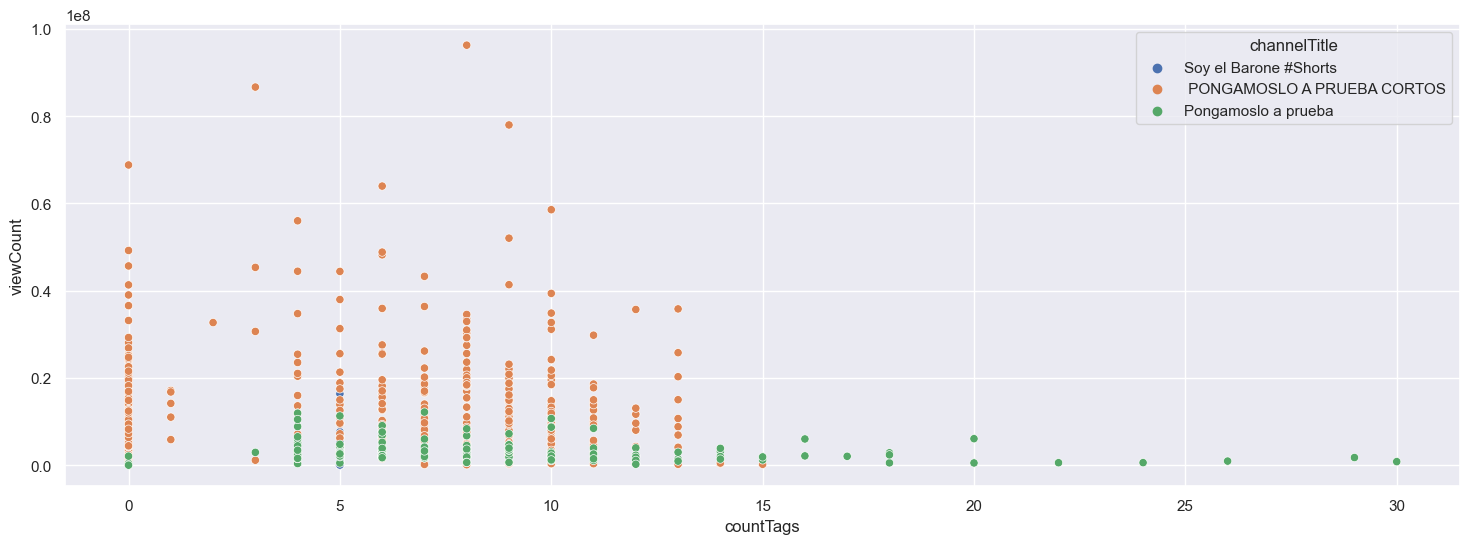

In [57]:
sns.scatterplot(data = videos_df, x = "countTags", y = "viewCount", hue="channelTitle", palette="deep")

### Which day in the week are most videos uploaded?

The diference between the days is not very big, but it seems that most videos are uploaded on Monday and Tuesday.

In [60]:
day_df = pd.DataFrame(videos_df['publishedAtDay'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
day_df.reset_index(inplace=True)

<Axes: xlabel='publishedAtDay', ylabel='count'>

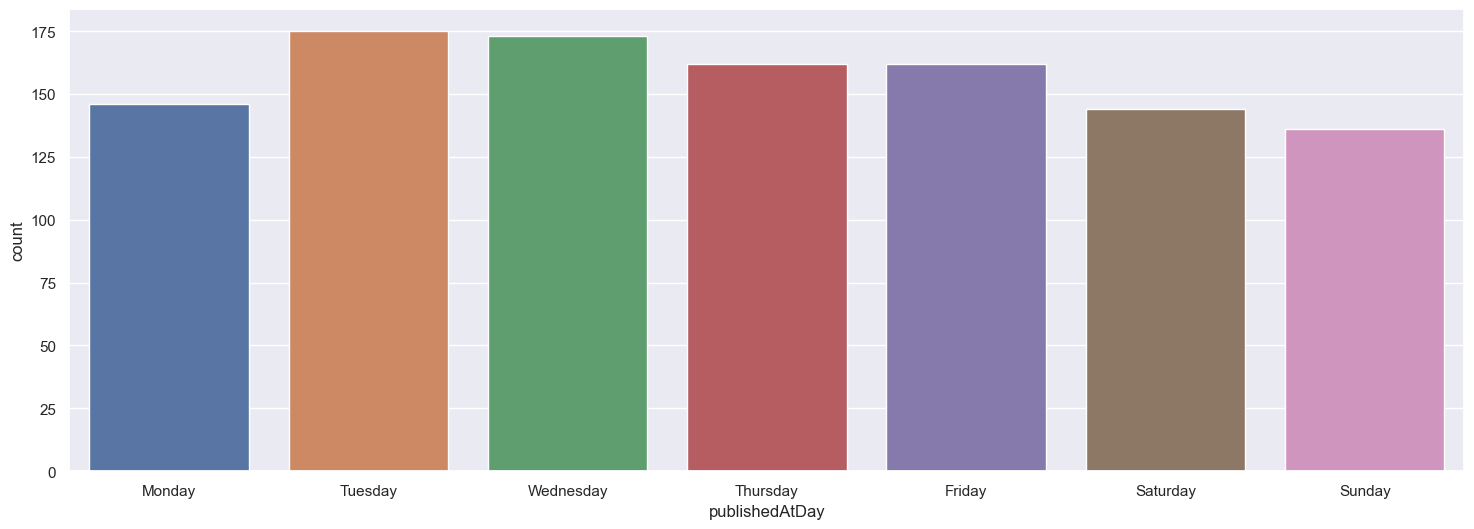

In [68]:
sns.barplot(data=day_df,y="count", x='publishedAtDay', errorbar=None)

### Wordcloud for video comments

We can see what are the frequently-mentioned words in the video comments. I will do this by visualizing the keywords in a wordcloud.

In [ ]:
stop_words = set(stopwords.words('spanish'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

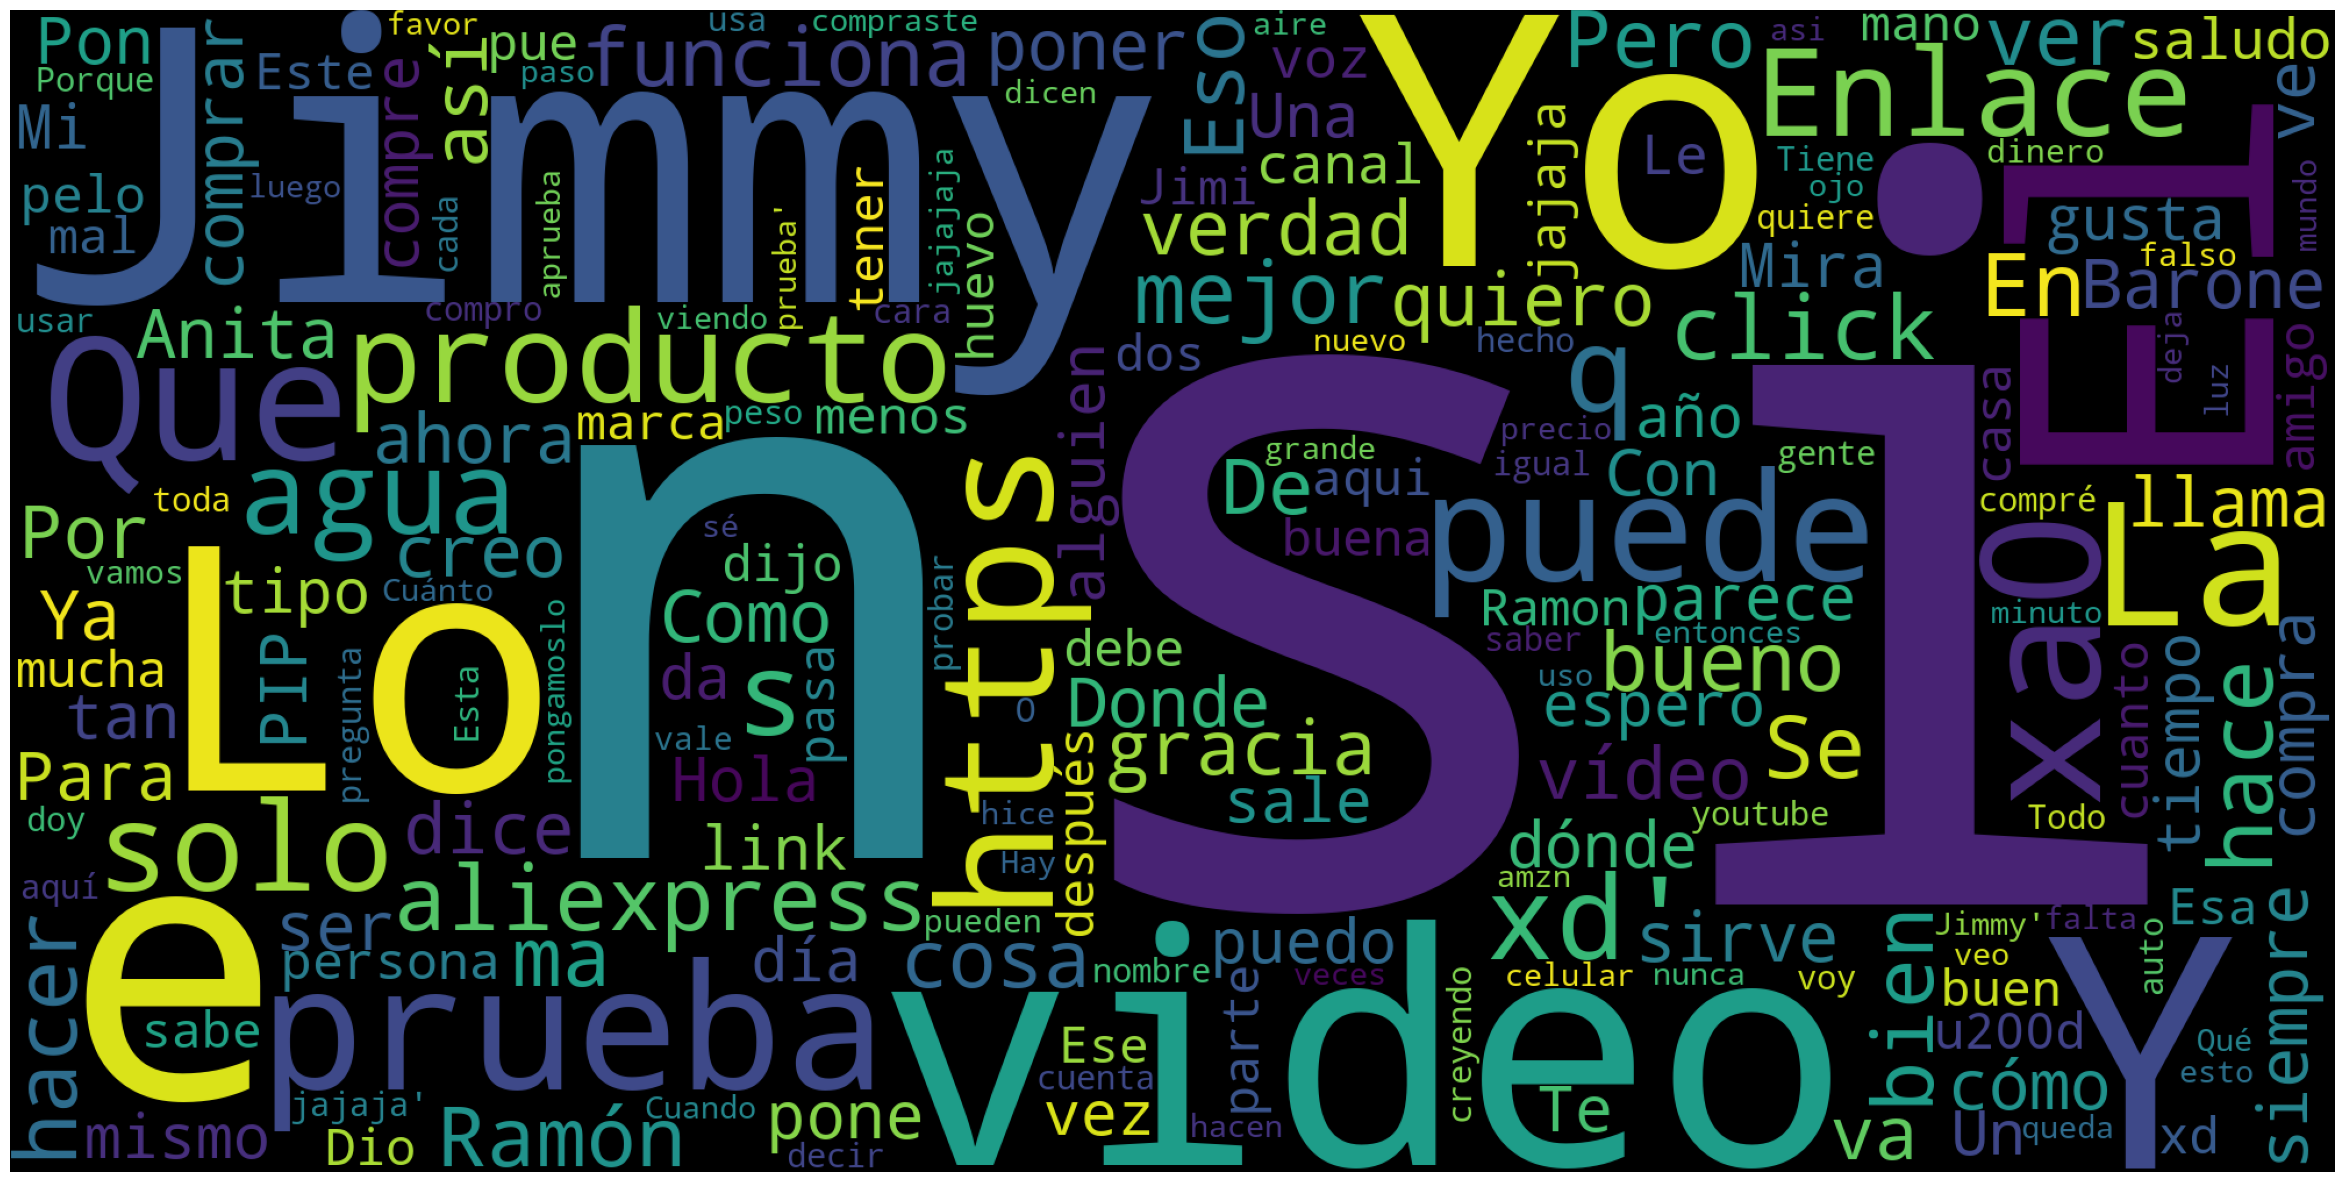

In [ ]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

We can see that next to the obvious words such as "video", "Jimmy"( channel owner), the most frequent words are quite positive, such as "gracias", "si", "bueno" y "quiero".

### Conclusions and future research ideas
In this project, we have explored the video data of the 3 product review channels and revealed many interesting findings.

- The more likes and comments a video has, the more views the video gets (it is not guaranteed that this is a causal relationship, it is simply a correlation and can work both way). Likes seem to be a better indicator for interaction than comments and the number of likes seem to follow the "social proof", which means the more views the video has, the more people will like it.

- Most videos have between 0 and 15 tags.

- There is not a clear correlation between title length and views.

- Do not exist a clear specific best day where the videos most be uploaded. 

- Comments on videos are generally positive.


#### Project limitation:

The findings should also be taken with a grain of salt for a number of reasons:

The number of videos is quite small (the dataset has only ~1,000 videos)

I have only considered the first 10 comments on each video, which might not be representative for all comments

There are many other factors that haven't been taken into the analysis, including the marketing strategy of the creators and many random effects that would affect how successful a video is



#### Ideas for future research:

To expand and build on this research project, one can:

Expand the dataset to more channels in product review niche

Do sentiment analysis on the comments and find out which videos get more positive comments and which videos get less positive comments

Do market research by analyzing questions in the comment threads and identifying common questions/ market gaps which could potentially filled

Conduct this research for other niches (e.g. vlogs or beauty channels), to compare different niches with each other to see the different patterns in viewership and video characteristics.



#### References/ Resources used:

[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] Converting video durations to time function. https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3